# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import os
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


#### Path management

In [2]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.path.join(os.getcwd())

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# EDA

In [3]:
df_sample_submission = pd.read_csv(get_full_dir('input/playground-series-s3e13/sample_submission.csv'))
df_train = pd.read_csv(get_full_dir('input/playground-series-s3e13/train.csv'), index_col='id')
df_test = pd.read_csv(get_full_dir('input/playground-series-s3e13/test.csv'), index_col='id')

In [4]:
df_train.isna().sum()

sudden_fever      0
headache          0
mouth_bleed       0
nose_bleed        0
muscle_pain       0
                 ..
ulcers            0
toenail_loss      0
speech_problem    0
bullseye_rash     0
prognosis         0
Length: 65, dtype: int64

There are no missing values in our train data.

In [5]:
df_sample_submission.head()

,id,prognosis
0,707,Dengue Zika Japanese_encephalitis
1,708,Dengue Zika Japanese_encephalitis
2,709,Dengue Zika Japanese_encephalitis
3,710,Dengue Zika Japanese_encephalitis
4,711,Dengue Zika Japanese_encephalitis


In [6]:
df_train.head()

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever


In [7]:
df_train.describe()

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
count,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,...,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000,707.000000
mean,0.503536,0.449788,0.459689,0.487977,0.517680,0.449788,0.441301,0.487977,0.390382,0.393211,...,0.148515,0.072136,0.097595,0.079208,0.084866,0.154173,0.144272,0.137199,0.032532,0.031117
std,0.500341,0.497825,0.498725,0.500209,0.500041,0.497825,0.496894,0.500209,0.488181,0.488809,...,0.355861,0.258896,0.296977,0.270254,0.278879,0.361370,0.351614,0.344301,0.177533,0.173758
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


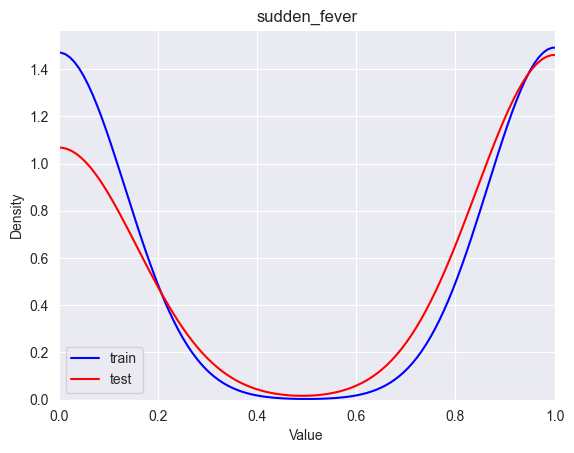

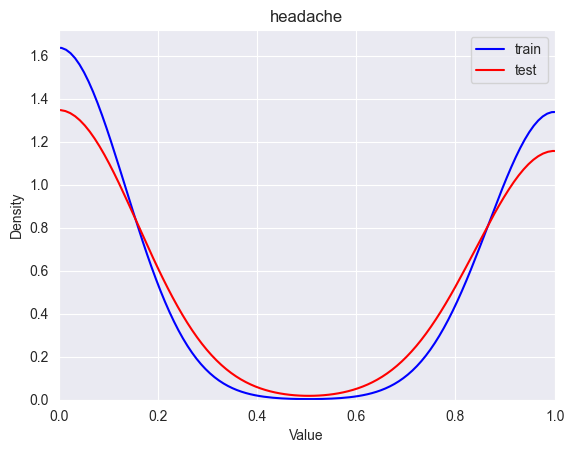

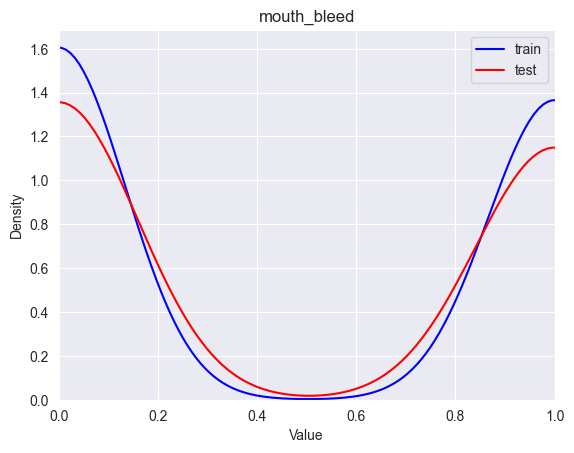

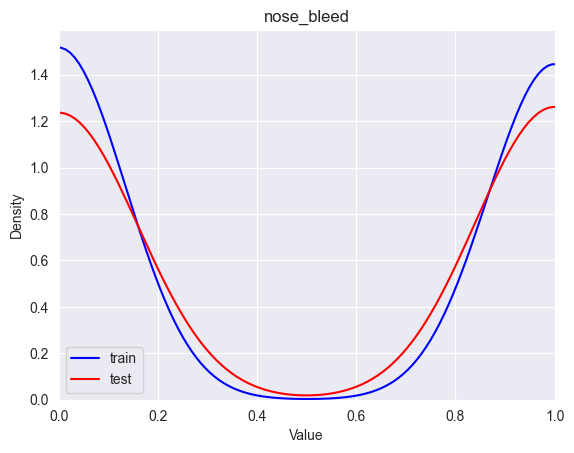

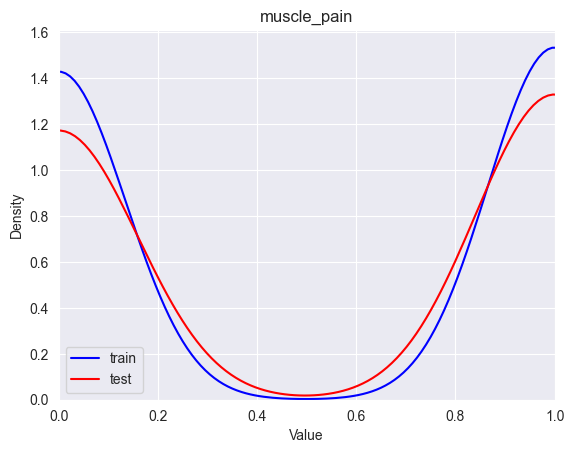

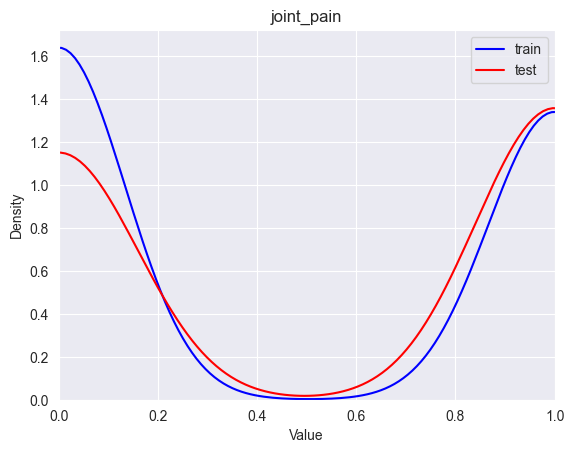

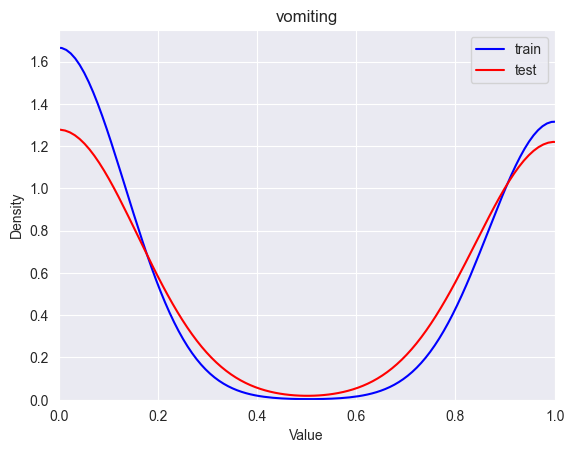

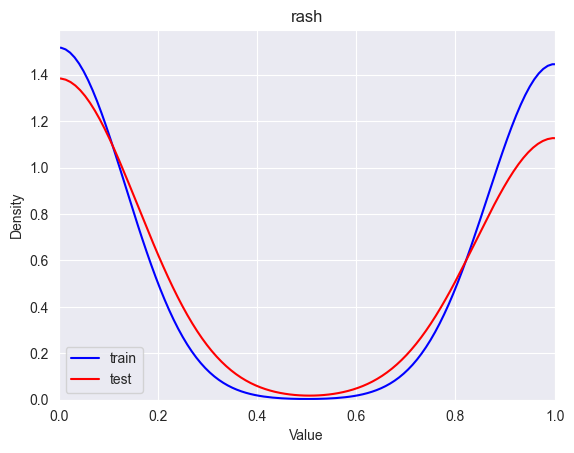

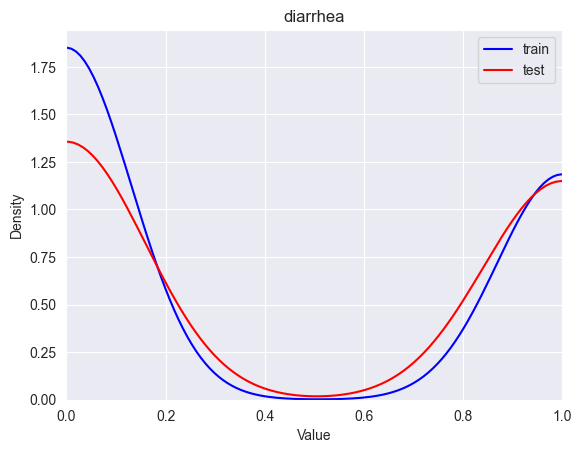

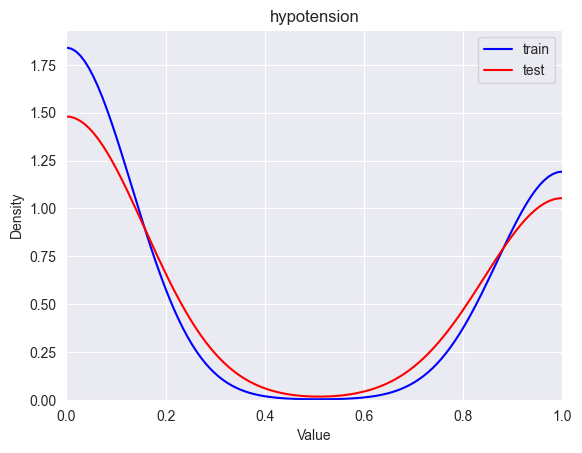

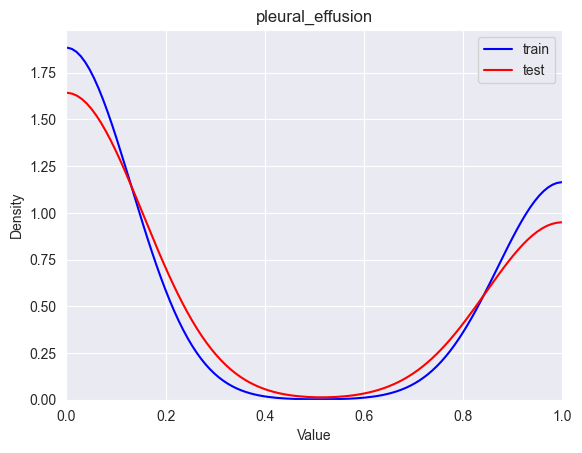

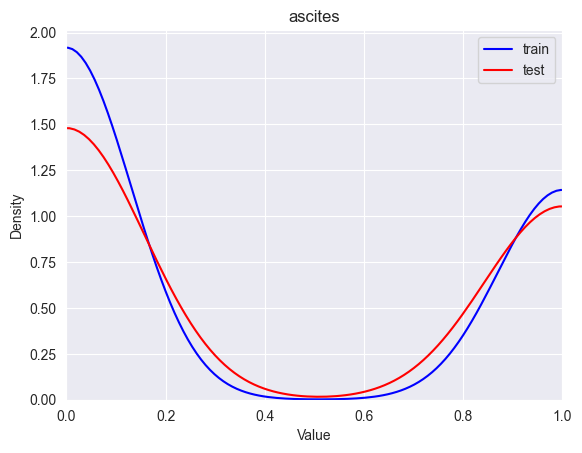

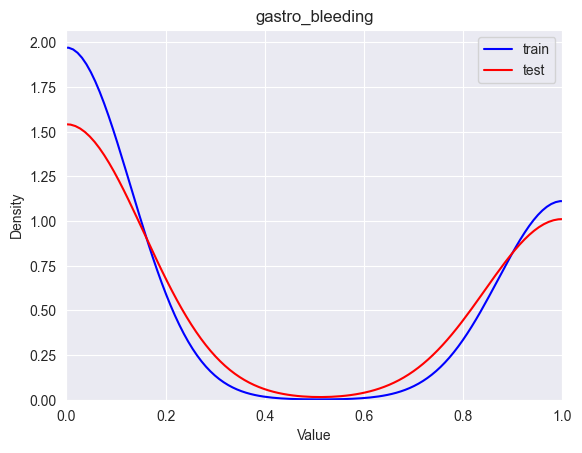

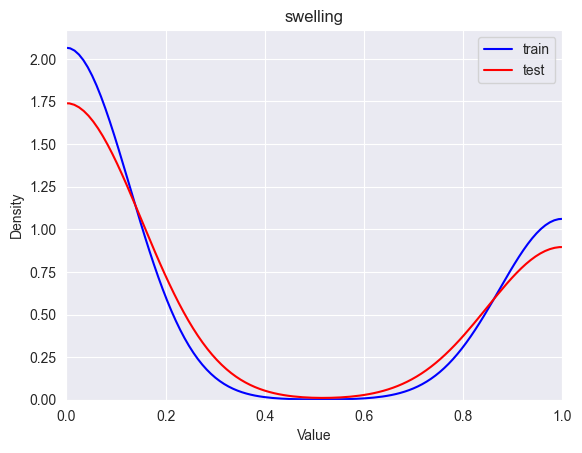

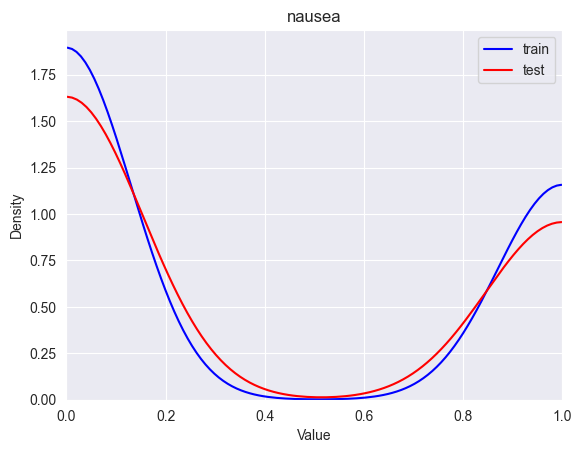

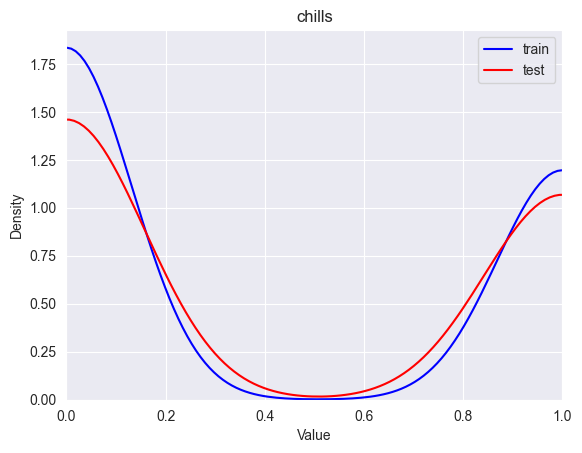

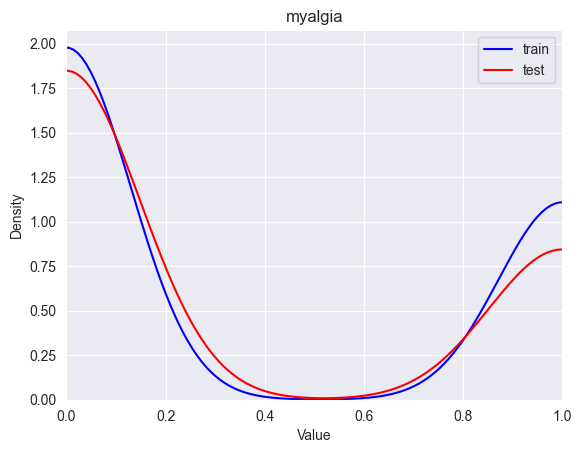

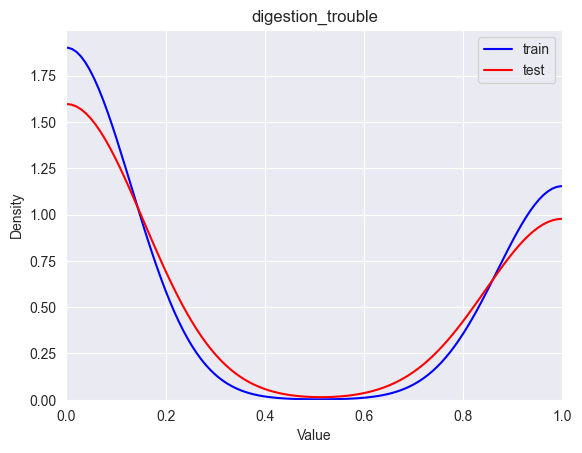

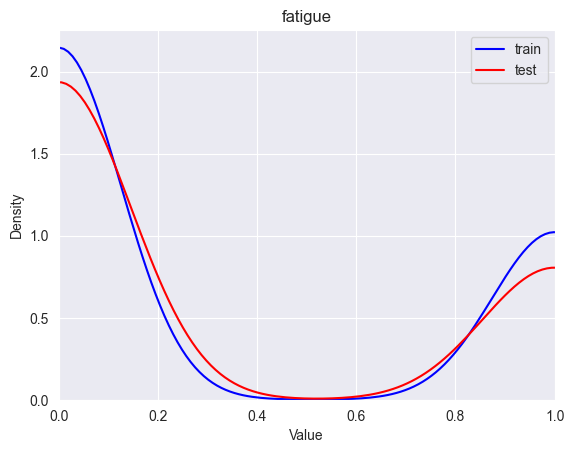

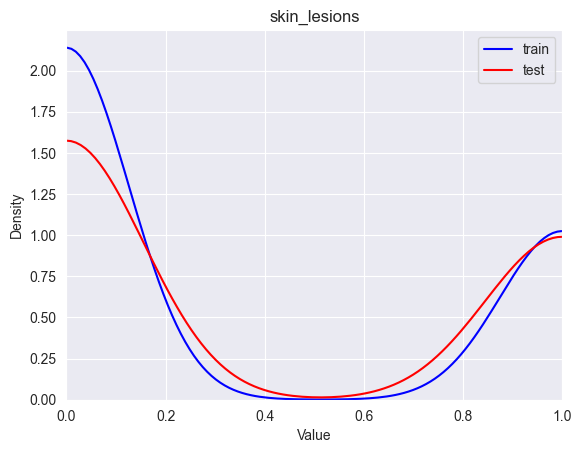

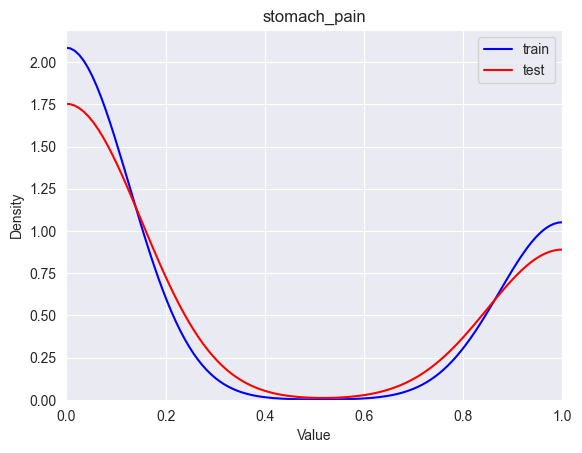

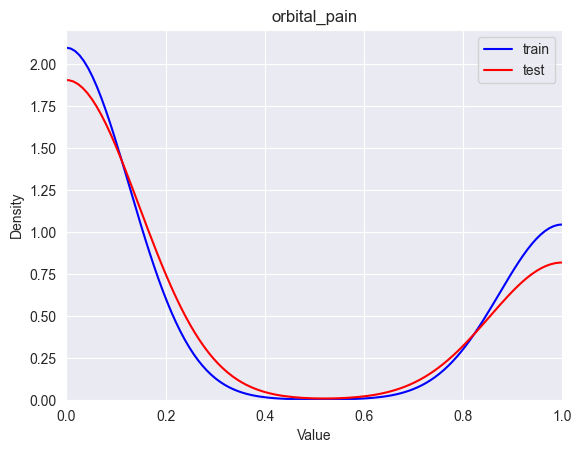

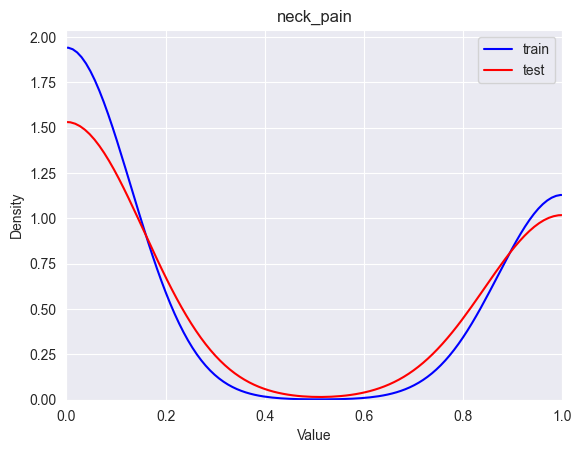

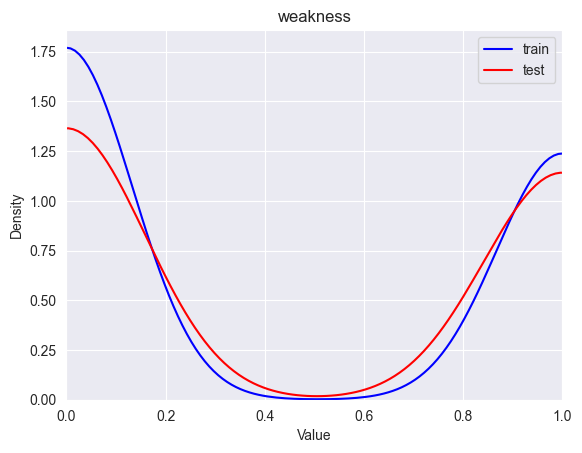

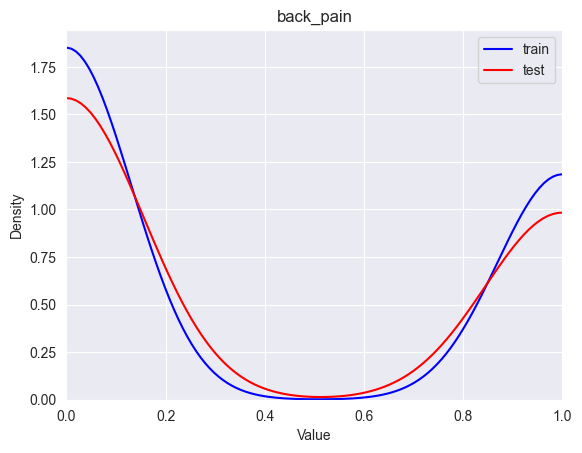

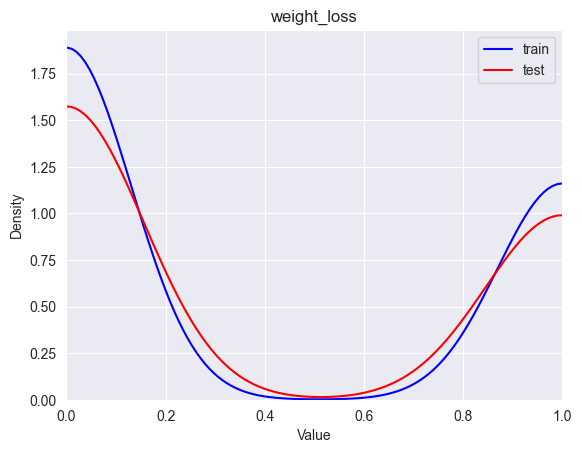

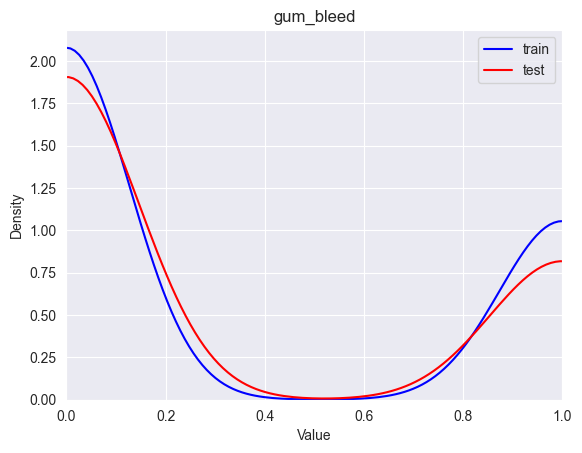

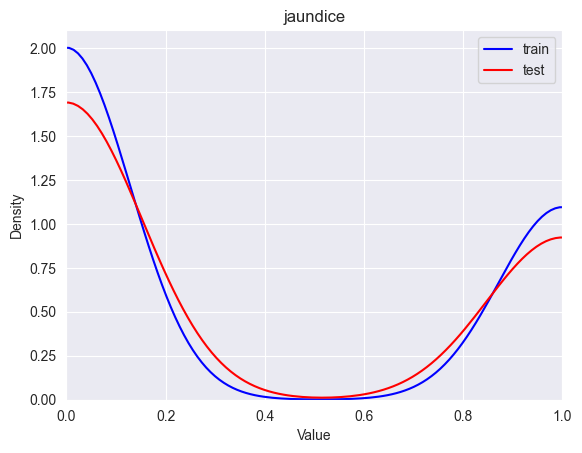

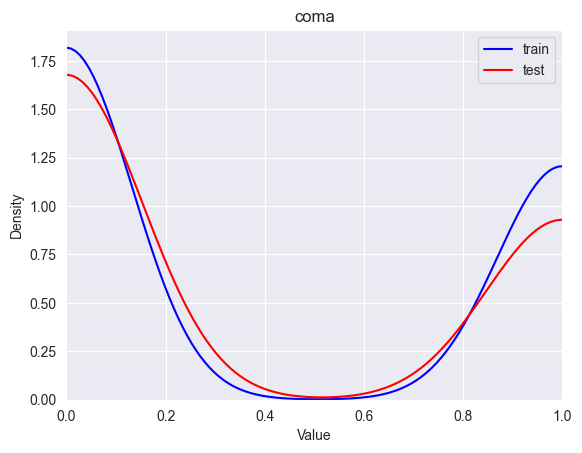

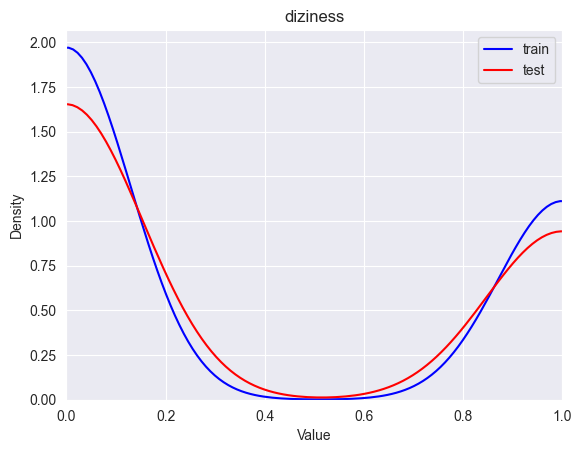

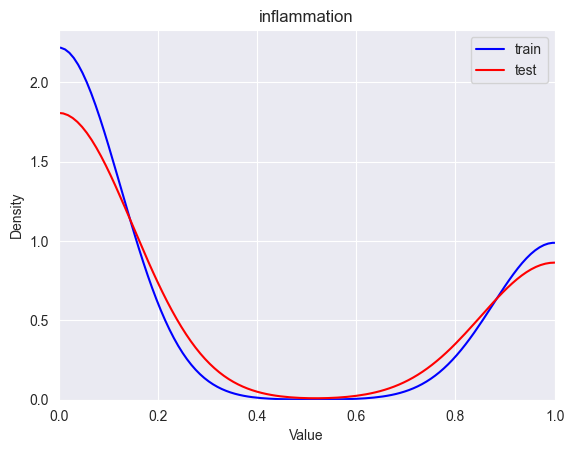

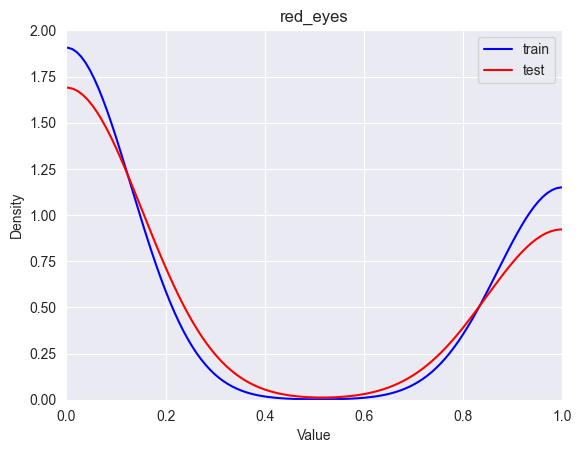

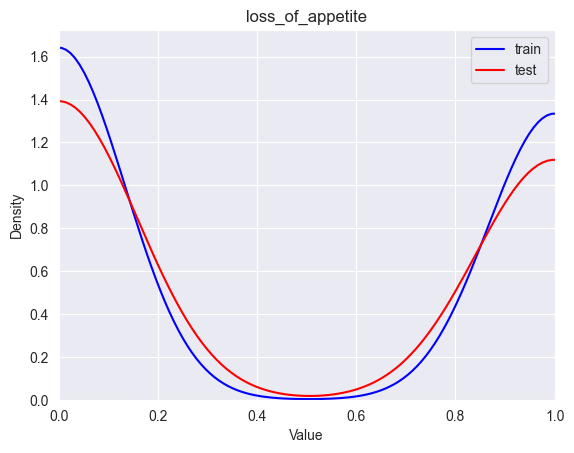

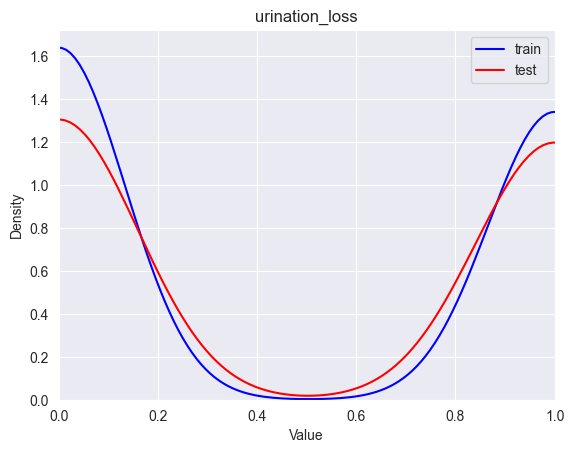

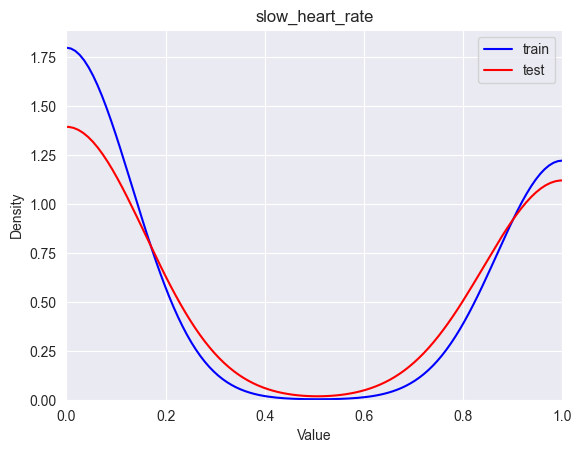

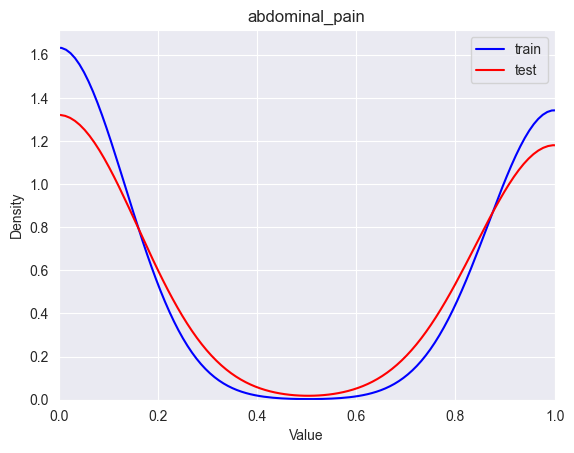

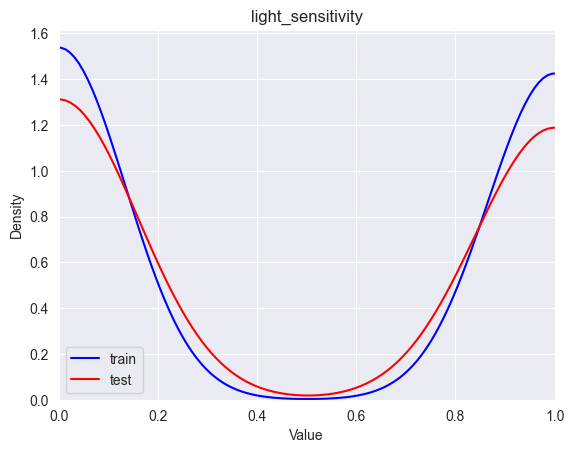

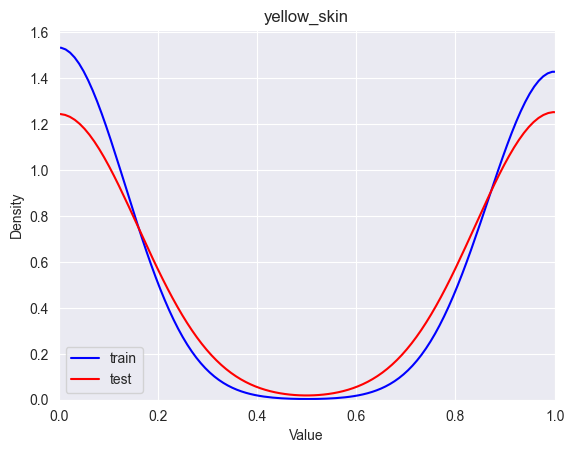

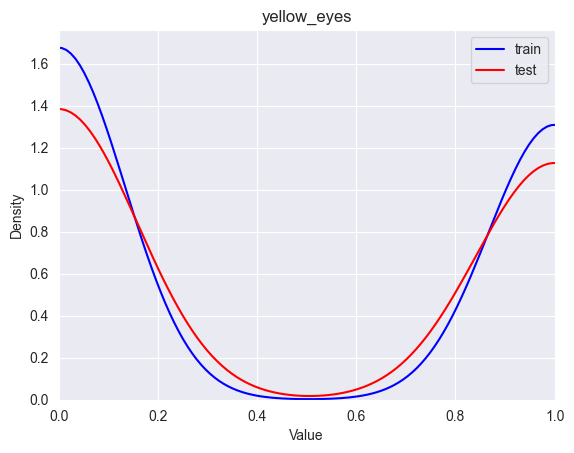

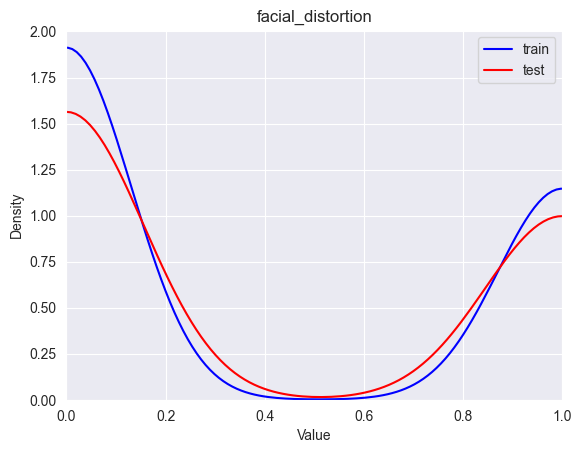

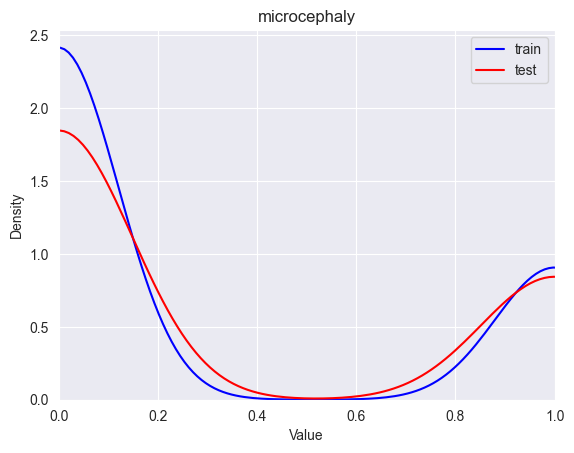

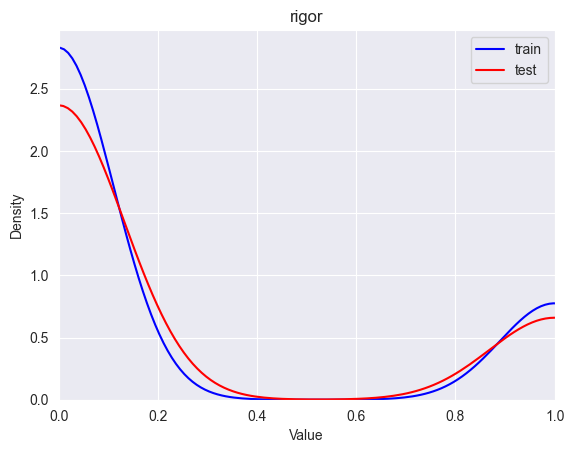

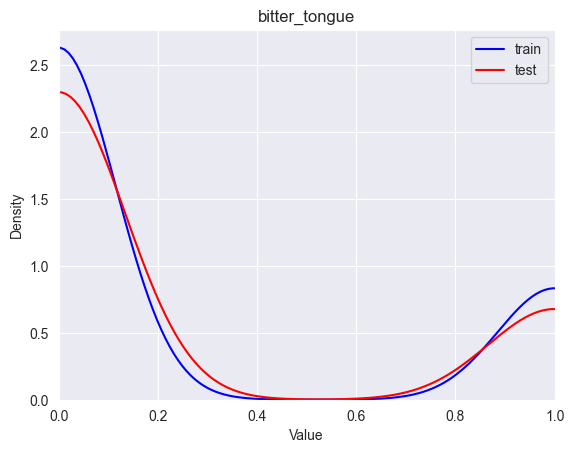

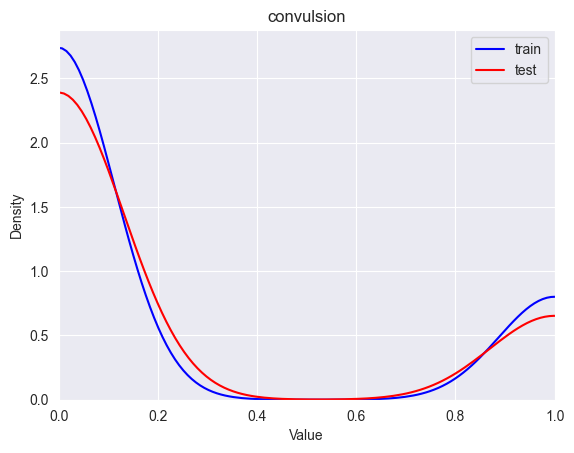

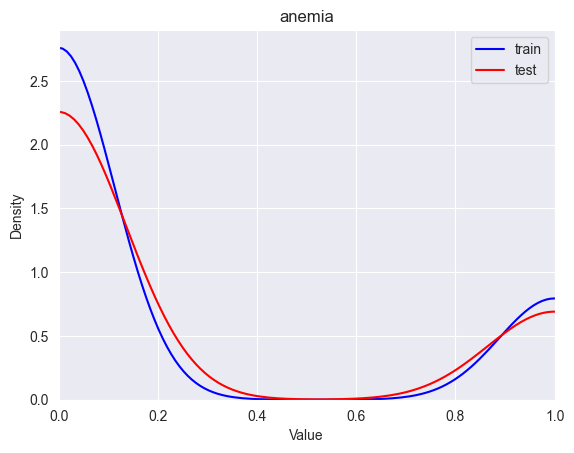

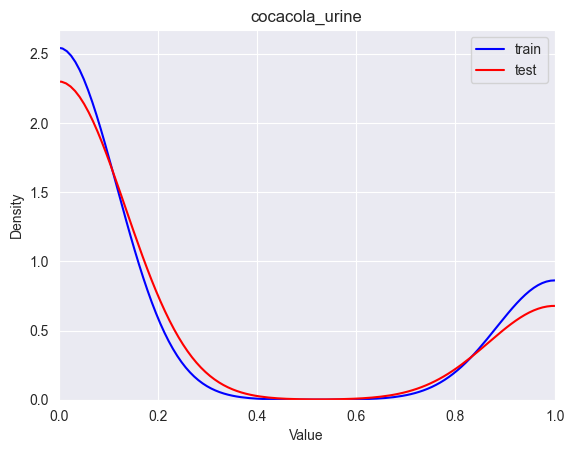

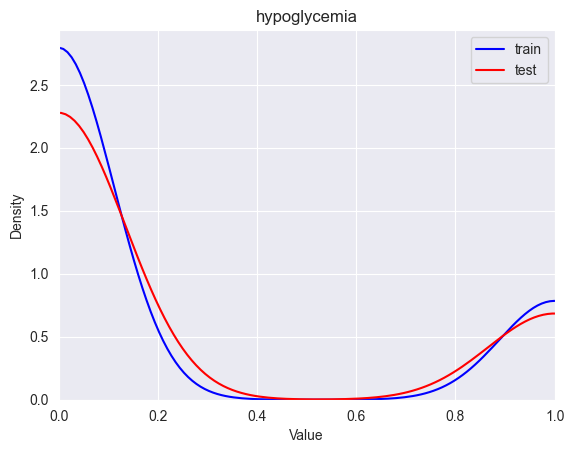

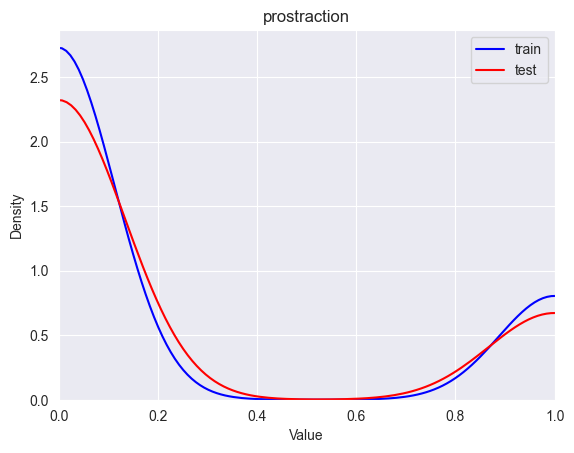

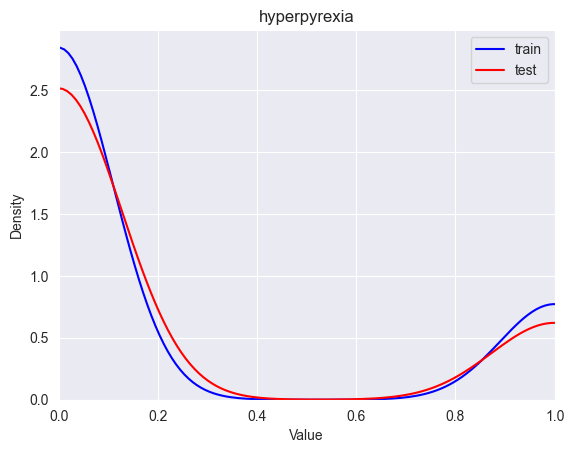

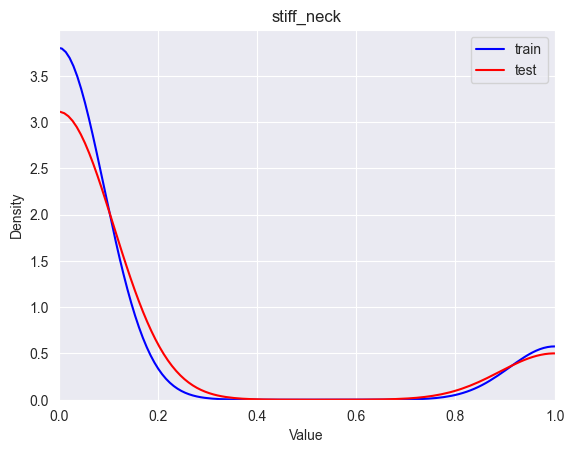

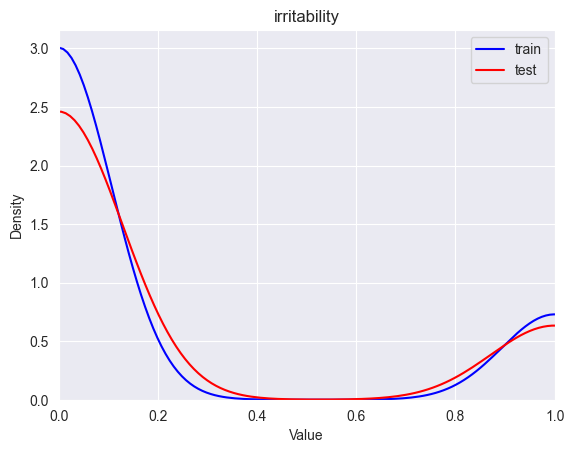

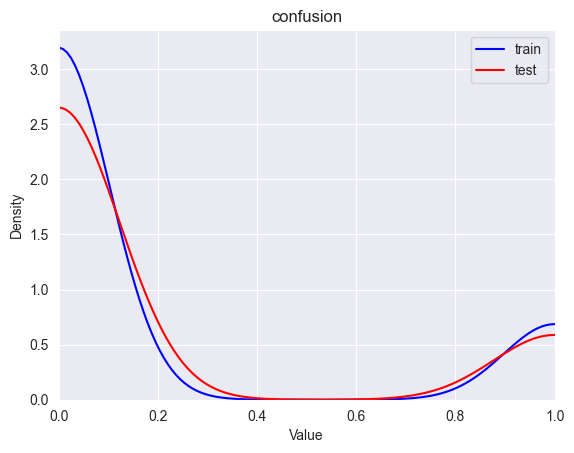

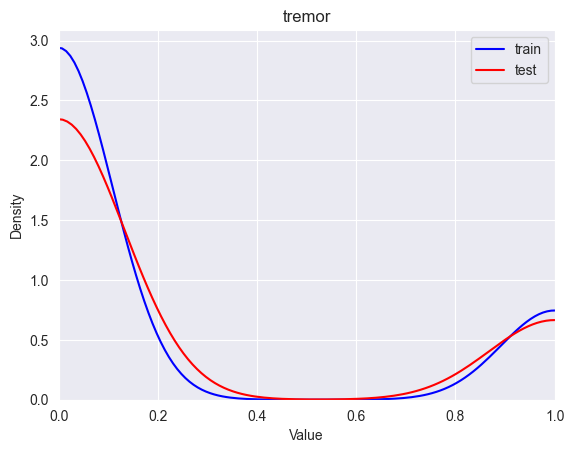

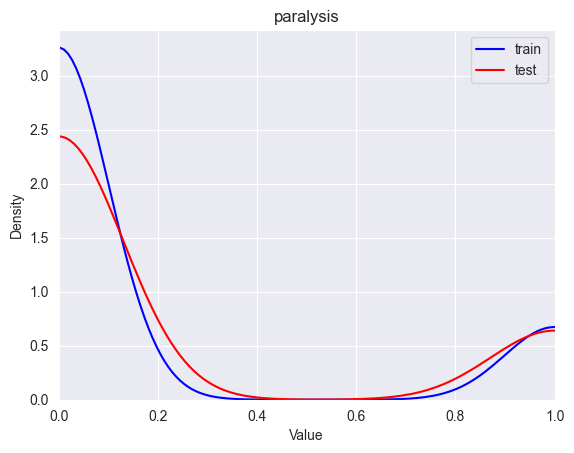

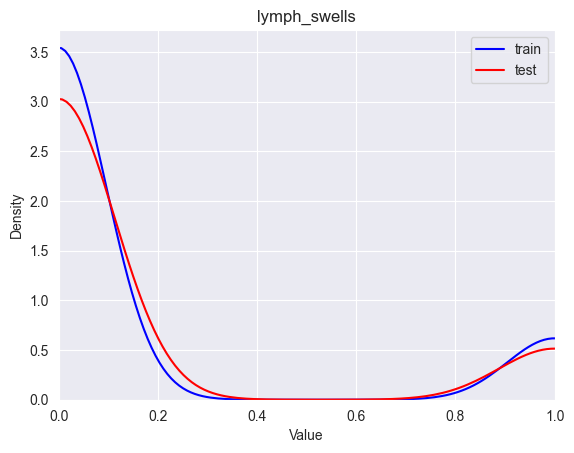

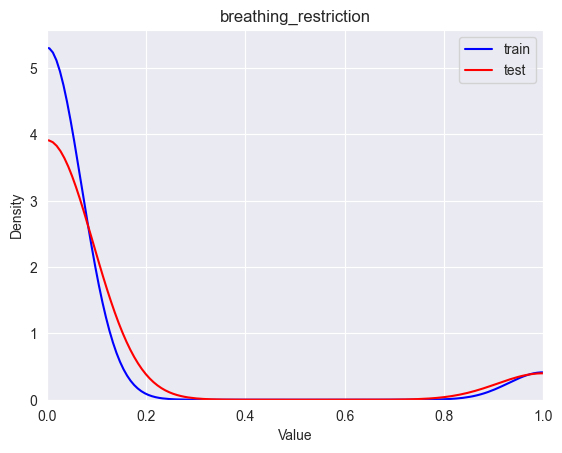

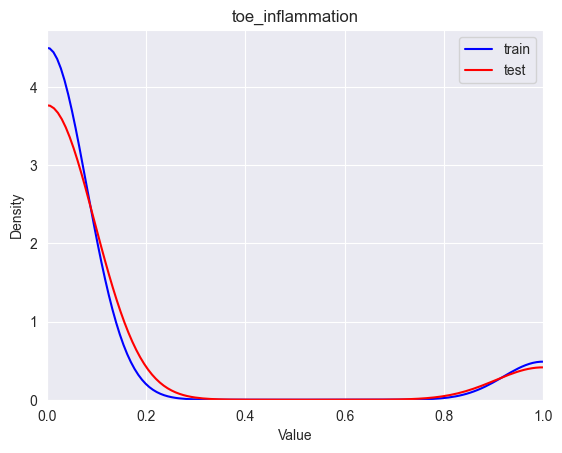

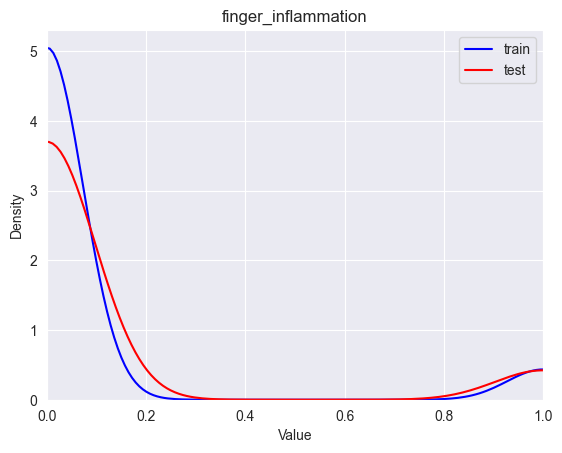

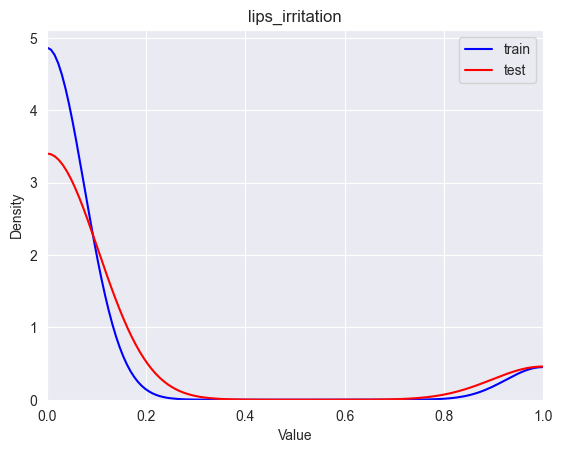

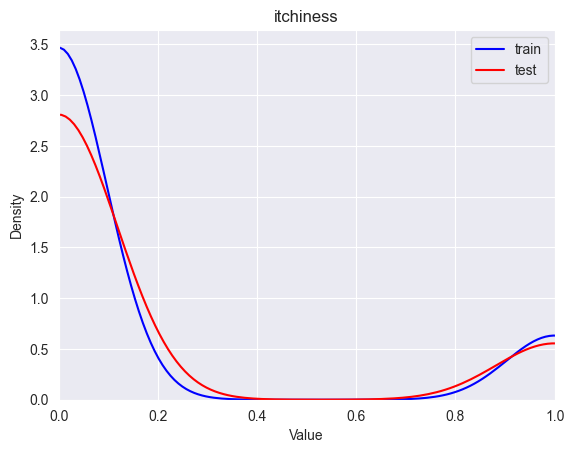

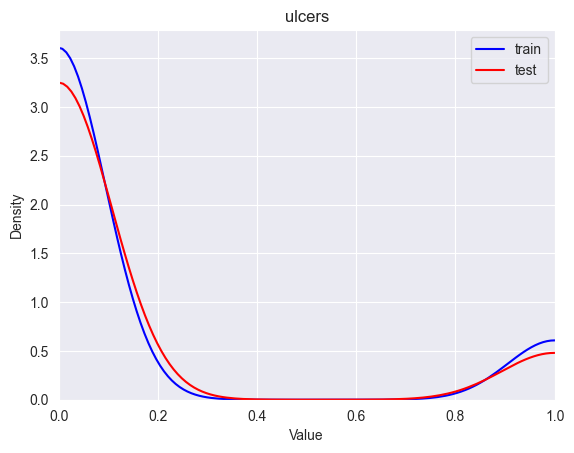

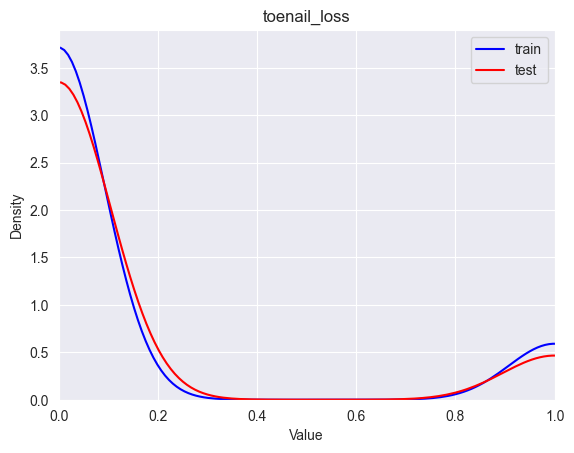

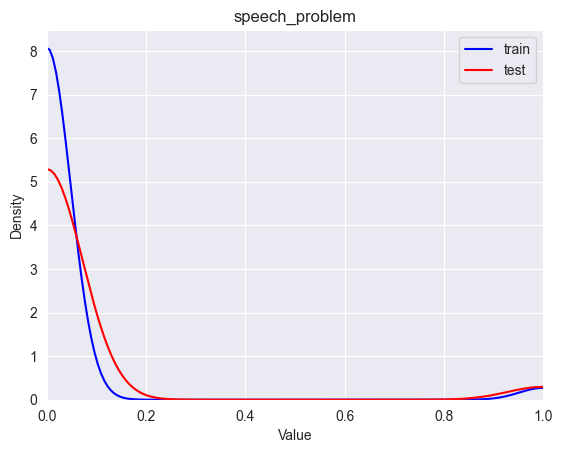

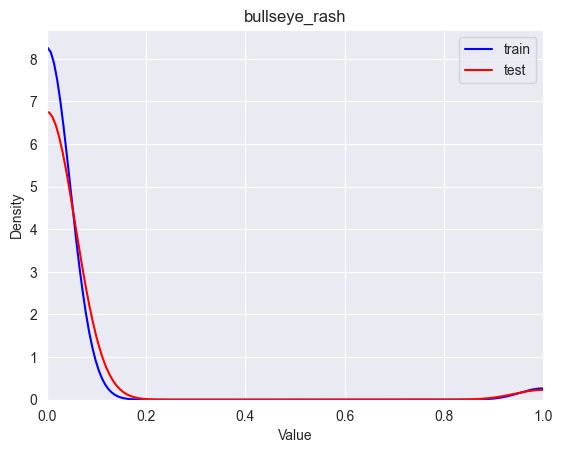

In [8]:
for col in df_train.select_dtypes(include='number').columns:
    plt.figure()
    sns.kdeplot(df_train[col], color='blue', label='train', fill=False)
    sns.kdeplot(df_test[col], color='red', label='test', fill=False)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.xlim(0, 1)
    plt.legend()
    plt.show()

Features of Train and Test data sets are similarly distributed

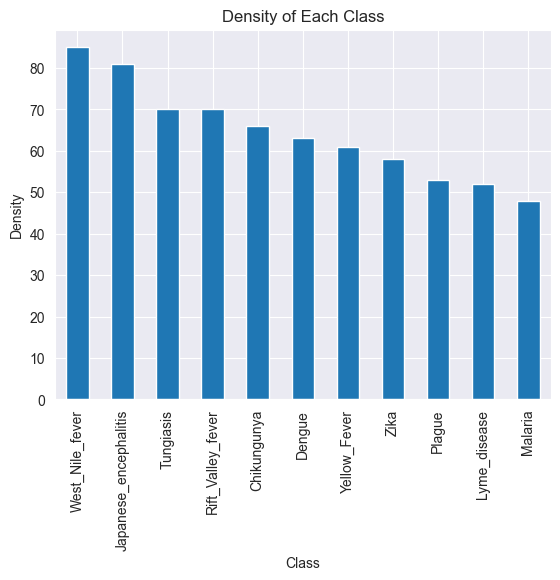

In [9]:
# count the number of occurrences of each class
class_counts = df_train['prognosis'].value_counts()

# create a bar plot of the class counts
class_counts.plot(kind='bar')

# set plot title and axis labels
plt.title('Density of Each Class')
plt.xlabel('Class')
plt.ylabel('Density')

# display the plot
plt.show()

# Train Models

In [10]:
print(len(df_train.columns))
enc = LabelEncoder()
df_train['prognosis'] = enc.fit_transform(df_train['prognosis'])
print(len(df_train.columns))
df_train.head()

65
65


,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,6


In [11]:
def apk(actual, predicted, k = 10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k = 10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [12]:
def selecting_top_3(arr):
    n = arr.shape[0]
    out = np.zeros((n, 3))
    for i in range(0, n):
        out[i, ] = arr[i,].argsort()[::-1][:3]
    return out.astype('int32')

In [13]:
class Pipeline:

    def __init__(self, model='XGB'):
        self.model_type = model
        if model == 'LGB':
            self.model = lgb.LGBMClassifier(
                num_leaves = 16,
                learning_rate = 0.01,
                early_stopping_rounds = 100,
                n_estimators=2000,
                objective = "softmax",
            )
        elif model == 'CatBoost':
            self.model = CatBoostClassifier(
                iterations=1000,
                learning_rate=0.01,
                loss_function='MultiClass',
                eval_metric='MultiClass',
                depth=2,
            )
        else:
            self.model = xgb.XGBClassifier(objective = 'multi:softprob',
                                           tree_method = 'gpu_hist',
                                           colsample_bytree = 0.6,
                                           gamma = 0.8,
                                           learning_rate = 0.01,
                                           max_depth = 5,
                                           min_child_weight = 5,
                                           n_estimators = 500,
                                           subsample = 0.7)

    def fit(self, X, y, X_val, y_val):
        self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], verbose=False)

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def grid_search(self, X, y, X_eval, y_eval):
       pass

In [14]:
from sklearn.metrics import cohen_kappa_score


def train(model_type):
    X = df_train.drop(['prognosis'], axis=1)
    y = df_train['prognosis']
    SKFs = KFold(n_splits=5, shuffle=True, random_state=1)
    losses = []
    pipelines = []
    for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
        # splits data to dev/train sets and removes outliers from train data
        train_dataframe = df_train.iloc[idx_tr]
        # it appears that removing outliers drasticly hurt the models accrecy,
        # i will have the review the this topic
        #train_dataframe = remove_outliers(train_dataframe)
        dev_dataframe = df_train.iloc[idx_vl]

        # splits data to features and target
        X_train = train_dataframe.drop('prognosis', axis=1)
        y_train = train_dataframe['prognosis']
        X_dev = dev_dataframe.drop('prognosis', axis=1)
        y_dev = dev_dataframe['prognosis']

        # crates and fits a pipeline
        pipelineMy = Pipeline(model=model_type)
        pipelineMy.fit(X_train, y_train, X_dev, y_dev)

        # evaluates the model
        pipelines.append(pipelineMy)
        #loss = cohen_kappa_score(y_dev, pipelineMy.predict(X_dev), weights = "quadratic")
        prediction = selecting_top_3(pipelineMy.predict_proba(X))
        loss = mapk(y_dev.values.reshape(-1, 1), prediction, k=3)
        losses.append(loss)
        print(f'Fold {fold} loss: {loss}')
    print(f'Mean loss: {np.array(losses).mean()}')
    return losses, pipelines

In [15]:
lossesLGB, pipelinesLGB = train('LGB')

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 loss: 0.1384976525821596
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 loss: 0.16431924882629106
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 loss: 0.17848699763593381
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 loss: 0.15602836879432624
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 4 loss: 0.11583924349881795
Mean loss: 0.1506343022675057


In [16]:
lossesCB, pipelinesCB = train('CatBoost')

Fold 0 loss: 0.12793427230046947
Fold 1 loss: 0.176056338028169
Fold 2 loss: 0.16430260047281323
Fold 3 loss: 0.16548463356973997
Fold 4 loss: 0.12529550827423167
Mean loss: 0.15181467052908465


In [17]:
lossesXGB, pipelinesXGB = train('XGB')

Fold 0 loss: 0.14084507042253522
Fold 1 loss: 0.15140845070422534
Fold 2 loss: 0.1442080378250591
Fold 3 loss: 0.17612293144208038
Fold 4 loss: 0.10756501182033096
Mean loss: 0.1440299004428462


# Make Submission

In [18]:
preds = pipelinesLGB[0].predict_proba(df_test)
for i in range(1, len(pipelinesLGB)):
    preds += pipelinesLGB[0].predict_proba(df_test)
for i in range(1, len(pipelinesXGB)):
    preds += pipelinesXGB[0].predict_proba(df_test)
for i in range(1, len(pipelinesCB)):
    preds += pipelinesCB[0].predict_proba(df_test)
preds = selecting_top_3(preds)
preds = pd.DataFrame(preds)
for i in range(3):
    preds[i] = enc.inverse_transform(preds[i])

In [19]:
preds

,0,1,2
0,Rift_Valley_fever,Chikungunya,Dengue
1,Dengue,Chikungunya,West_Nile_fever
2,West_Nile_fever,Japanese_encephalitis,Rift_Valley_fever
3,Japanese_encephalitis,Rift_Valley_fever,Chikungunya
4,Japanese_encephalitis,West_Nile_fever,Plague
...,...,...,...
298,Yellow_Fever,West_Nile_fever,Japanese_encephalitis
299,Lyme_disease,Malaria,Plague
300,West_Nile_fever,Lyme_disease,Malaria
301,West_Nile_fever,Rift_Valley_fever,Zika


In [20]:
submission = pd.DataFrame()
submission['prognosis'] = preds[0] + " " + preds[1] + " " + preds[2]
submission.index += 707

In [21]:
submission

,prognosis
707,Rift_Valley_fever Chikungunya Dengue
708,Dengue Chikungunya West_Nile_fever
709,West_Nile_fever Japanese_encephalitis Rift_Val...
710,Japanese_encephalitis Rift_Valley_fever Chikun...
711,Japanese_encephalitis West_Nile_fever Plague
...,...
1005,Yellow_Fever West_Nile_fever Japanese_encephal...
1006,Lyme_disease Malaria Plague
1007,West_Nile_fever Lyme_disease Malaria
1008,West_Nile_fever Rift_Valley_fever Zika


In [22]:
submission.to_csv("submission.csv", index=True, header=True, index_label="id")